# This tutorial shows how to make and manipulate a cross spectrum of two light curves using Stingray.

In [1]:
import numpy as np
from stingray import Lightcurve, Crossspectrum, AveragedCrossspectrum

import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
%matplotlib inline
font_prop = font_manager.FontProperties(size=16)

/home/theswapsha96/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Cross spectrum example
## 1. Create two light curves
There are two ways to make `Lightcurve` objects. We'll show one way here. Check out "Lightcurve/Lightcurve\ tutorial.ipynb" for more examples.

Generate an array of relative timestamps that's 8 seconds long, with dt = 0.03125 s, and make two signals in units of counts. The first is a sine wave with amplitude = 300 cts/s, frequency = 2 Hz, phase offset = 0 radians, and mean = 1000 cts/s. The second is a sine wave with amplitude = 200 cts/s, frequency = 2 Hz, phase offset = pi/4 radians, and mean = 900 cts/s. We then add Poisson noise to the light curves.

In [2]:
dt = 0.03125  # seconds
exposure = 8.  # seconds
times = np.arange(0, exposure, dt)  # seconds

signal_1 = 300 * np.sin(2.*np.pi*times/0.5) + 1000  # counts/s
signal_2 = 200 * np.sin(2.*np.pi*times/0.5 + np.pi/4) + 900  # counts/s
noisy_1 = np.random.poisson(signal_1*dt)  # counts
noisy_2 = np.random.poisson(signal_2*dt)  # counts

Now let's turn `noisy_1` and `noisy_2` into `Lightcurve` objects.

In [3]:
lc1 = Lightcurve(times, noisy_1)
lc2 = Lightcurve(times, noisy_2)

Here we're plotting them to see what they look like.

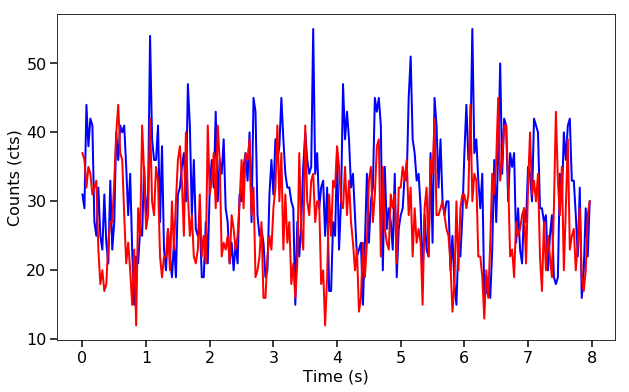

In [4]:
fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.plot(lc1.time, lc1.counts, lw=2, color='blue')
ax.plot(lc1.time, lc2.counts, lw=2, color='red')
ax.set_xlabel("Time (s)", fontproperties=font_prop)
ax.set_ylabel("Counts (cts)", fontproperties=font_prop)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.tick_params(which='major', width=1.5, length=7)
ax.tick_params(which='minor', width=1.5, length=4)
plt.show()

## 2. Pass both of the light curves to the `Crossspectrum` class to create a `Crossspectrum` object.
The first `Lightcurve` passed is the channel of interest or interest band, and the second `Lightcurve` passed is the reference band.
You can also specify the optional attribute `norm` if you wish to normalize the real part of the cross spectrum to squared fractional rms, Leahy, or squared absolute normalization. The default normalization is 'none'.

In [5]:
cs = Crossspectrum(lc1, lc2)
print(cs)

/home/theswapsha96/stingraysoftware/stingray/build/lib.linux-x86_64-3.6/stingray/utils.py:89: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


We can print the first five values in the arrays of the positive Fourier frequencies and the cross power. The cross power has a real and an imaginary component.

In [6]:
print(cs.freq[0:5])
print(cs.power[0:5])

[0.125 0.25  0.375 0.5   0.625]
[ -962.74541824+2314.33118895j -1851.9781954  -727.69420102j
 -3401.41257151+2502.50431931j  2316.99823097-2916.23110665j
 10468.7828801 +4437.23057245j]


Since the negative Fourier frequencies (and their associated cross powers) are discarded, the number of time bins per segment `n` is twice the length of `freq` and `power`.

In [7]:
print("Size of positive Fourier frequencies: %d" % len(cs.freq))
print("Number of data points per segment: %d" % cs.n)

Size of positive Fourier frequencies: 127
Number of data points per segment: 256


# Properties
A `Crossspectrum` object has the following properties :

1. `freq` : Numpy array of mid-bin frequencies that the Fourier transform samples.
2. `power` : Numpy array of the cross spectrum (complex numbers).
3. `df` : The frequency resolution.
4. `m` : The number of cross spectra averaged together. For a `Crossspectrum` of a single segment, `m=1`.
5. `n` : The number of data points (time bins) in one segment of the light curves.
6. `nphots1` : The total number of photons in the first (interest) light curve.
7. `nphots2` : The total number of photons in the second (reference) light curve.

We can compute the amplitude of the cross spectrum, and plot it as a function of Fourier frequency. Notice how there's a spike at our signal frequency of 2 Hz!

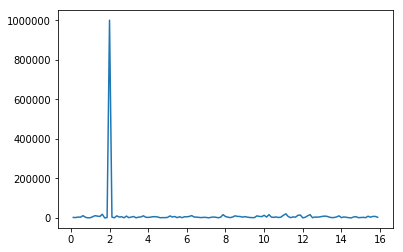

In [8]:
cs.plot()

You'll notice that the cross spectrum is a bit noisy. This is because we're only using one segment of data. Let's try averaging together multiple segments of data.
# Averaged cross spectrum example
You could use two long `Lightcurve`s and have `AveragedCrossspectrum` chop them into specified segments, or give two lists of `Lightcurve`s where each segment of `Lightcurve` is the same length. We'll show the first way here. Remember to check the Lightcurve tutorial notebook for fancier ways of making light curves.
## 1. Create two long light curves.
Generate an array of relative timestamps that's 1600 seconds long, and two signals in count rate units, with the same properties as the previous example. We then add Poisson noise and turn them into `Lightcurve` objects.

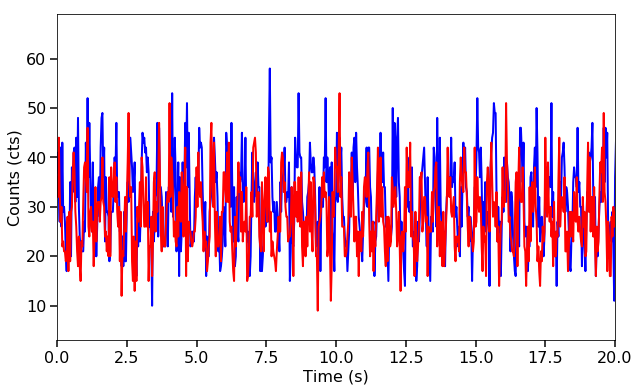

In [9]:
long_dt = 0.03125  # seconds
long_exposure = 1600.  # seconds
long_times = np.arange(0, long_exposure, long_dt)  # seconds

# In count rate units here
long_signal_1 = 300 * np.sin(2.*np.pi*long_times/0.5) + 1000  # counts/s
long_signal_2 = 200 * np.sin(2.*np.pi*long_times/0.5 + np.pi/4) + 900  # counts/s

# Multiply by dt to get count units, then add Poisson noise
long_noisy_1 = np.random.poisson(long_signal_1*dt)  # counts
long_noisy_2 = np.random.poisson(long_signal_2*dt)  # counts

long_lc1 = Lightcurve(long_times, long_noisy_1)
long_lc2 = Lightcurve(long_times, long_noisy_2)

fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.plot(long_lc1.time, long_lc1.counts, lw=2, color='blue')
ax.plot(long_lc1.time, long_lc2.counts, lw=2, color='red')
ax.set_xlim(0,20)
ax.set_xlabel("Time (s)", fontproperties=font_prop)
ax.set_ylabel("Counts (cts)", fontproperties=font_prop)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.tick_params(which='major', width=1.5, length=7)
ax.tick_params(which='minor', width=1.5, length=4)
plt.show()

## 2. Pass both light curves to the `AveragedCrossspectrum` class with a specified `segment_size`.
If the exposure (length) of the light curve cannot be divided by `segment_size` with a remainder of zero, the last incomplete segment is thrown out, to avoid signal artefacts. Here we're using 8 second segments.

In [10]:
avg_cs = AveragedCrossspectrum(long_lc1, long_lc2, 8.)

/home/theswapsha96/stingraysoftware/stingray/build/lib.linux-x86_64-3.6/stingray/utils.py:89: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


Again we can print the first five Fourier frequencies and first five cross spectral values, as well as the number of segments.

In [11]:
print(avg_cs.freq[0:5])
print(avg_cs.power[0:5])
print("\nNumber of segments: %d" % avg_cs.m)

[0.125 0.25  0.375 0.5   0.625]
[-344.61578449+625.15317651j   37.09849022 +26.71279788j
  529.27071541-526.71103064j  -68.07693044 -87.76505417j
  548.16946902 -21.84874127j]

Number of segments: 200


If `m` is less than 50 and you try to compute the coherence, a warning will pop up letting you know that your number of segments is significantly low, so the error on `coherence` might not follow the expected (Gaussian) statistical distributions.

In [12]:
test_cs = AveragedCrossspectrum(long_lc1, long_lc2, 40.)
print(test_cs.m)
coh, err = test_cs.coherence()

/home/theswapsha96/stingraysoftware/stingray/build/lib.linux-x86_64-3.6/stingray/utils.py:89: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


40


/home/theswapsha96/stingraysoftware/stingray/build/lib.linux-x86_64-3.6/stingray/utils.py:89: UserWarning: SIMON says: Number of segments used in averaging is significantly low. The result might not follow the expected statistical distributions.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


# Properties
An `AveragedCrossspectrum` object has the following properties, same as `Crossspectrum` :

1. `freq` : Numpy array of mid-bin frequencies that the Fourier transform samples.
2. `power` : Numpy array of the averaged cross spectrum (complex numbers).
3. `df` : The frequency resolution (in Hz).
4. `m` : The number of cross spectra averaged together, equal to the number of whole segments in a light curve.
5. `n` : The number of data points (time bins) in one segment of the light curves.
6. `nphots1` : The total number of photons in the first (interest) light curve.
7. `nphots2` : The total number of photons in the second (reference) light curve.

Let's plot the amplitude of the averaged cross spectrum!

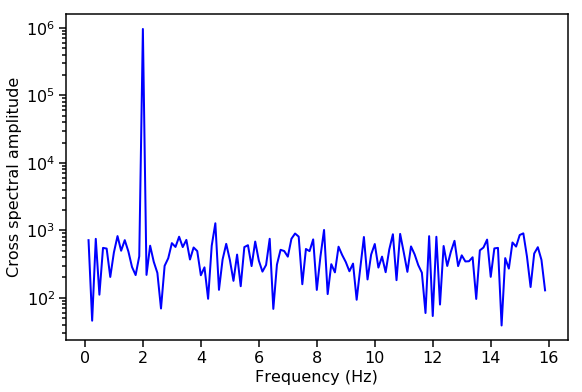

In [13]:
avg_cs_amplitude = np.abs(avg_cs.power)

fig, ax1 = plt.subplots(1,1,figsize=(9,6))
ax1.plot(avg_cs.freq, avg_cs_amplitude, lw=2, color='blue')
ax1.set_xlabel("Frequency (Hz)", fontproperties=font_prop)
ax1.set_ylabel("Cross spectral amplitude", fontproperties=font_prop)
ax1.set_yscale('log')
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.tick_params(which='major', width=1.5, length=7)
ax1.tick_params(which='minor', width=1.5, length=4)
for axis in ['top', 'bottom', 'left', 'right']:
    ax1.spines[axis].set_linewidth(1.5)
plt.show()

Now we'll show examples of all the things you can do with a `Crossspectrum` or `AveragedCrossspectrum` object using built-in stingray methods.

# Normalizating the cross spectrum
The three kinds of normalization are:
* `leahy`: Leahy normalization. Makes the Poisson noise level $= 2$. See *Leahy et al. 1983, ApJ, 266, 160L*. 
* `frac`: Fractional rms-squared normalization, also known as rms normalization. Makes the Poisson noise level $= 2 / \sqrt(meanrate_1\times meanrate_2)$. See *Belloni & Hasinger 1990, A&A, 227, L33*, and *Miyamoto et al. 1992, ApJ, 391, L21.*
* `abs`: Absolute rms-squared normalization, also known as absolute normalization. Makes the Poisson noise level $= 2 \times \sqrt(meanrate_1\times meanrate_2)$. See *insert citation*.
* `none`: No normalization applied. This is the default.

Note that these normalizations and the Poisson noise levels apply to the "cross power", not the cross-spectral amplitude.

In [14]:
avg_cs_leahy = AveragedCrossspectrum(long_lc1, long_lc2, 8., norm='leahy')
avg_cs_frac = AveragedCrossspectrum(long_lc1, long_lc2, 8., norm='frac')
avg_cs_abs = AveragedCrossspectrum(long_lc1, long_lc2, 8., norm='abs')

/home/theswapsha96/stingraysoftware/stingray/build/lib.linux-x86_64-3.6/stingray/utils.py:89: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


Here we plot the three normalized averaged cross spectra.

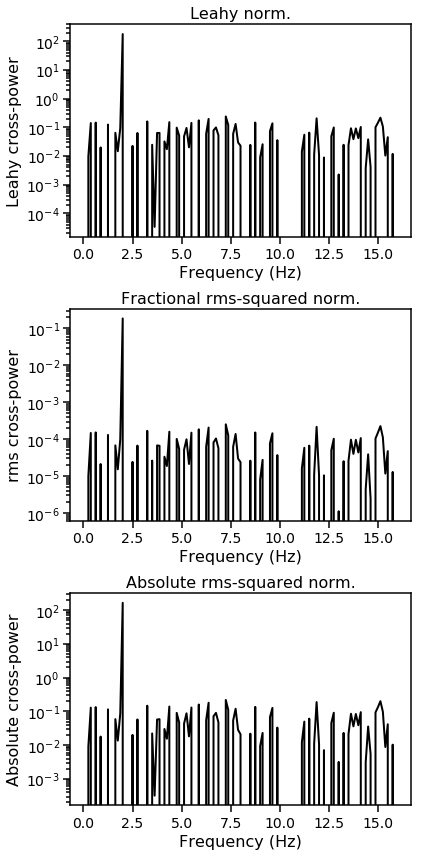

In [15]:
fig, [ax1, ax2, ax3] = plt.subplots(3,1,figsize=(6,12))
ax1.plot(avg_cs_leahy.freq, avg_cs_leahy.power, lw=2, color='black')
ax1.set_xlabel("Frequency (Hz)", fontproperties=font_prop)
ax1.set_ylabel("Leahy cross-power", fontproperties=font_prop)
ax1.set_yscale('log')
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
ax1.tick_params(which='major', width=1.5, length=7)
ax1.tick_params(which='minor', width=1.5, length=4)
ax1.set_title("Leahy norm.", fontproperties=font_prop)
    
ax2.plot(avg_cs_frac.freq, avg_cs_frac.power, lw=2, color='black')
ax2.set_xlabel("Frequency (Hz)", fontproperties=font_prop)
ax2.set_ylabel("rms cross-power", fontproperties=font_prop)
ax2.tick_params(axis='x', labelsize=14)
ax2.tick_params(axis='y', labelsize=14)
ax2.set_yscale('log')
ax2.tick_params(which='major', width=1.5, length=7)
ax2.tick_params(which='minor', width=1.5, length=4)
ax2.set_title("Fractional rms-squared norm.", fontproperties=font_prop)

ax3.plot(avg_cs_abs.freq, avg_cs_abs.power, lw=2, color='black')
ax3.set_xlabel("Frequency (Hz)", fontproperties=font_prop)
ax3.set_ylabel("Absolute cross-power", fontproperties=font_prop)
ax3.tick_params(axis='x', labelsize=14)
ax3.tick_params(axis='y', labelsize=14)
ax3.set_yscale('log')
ax3.tick_params(which='major', width=1.5, length=7)
ax3.tick_params(which='minor', width=1.5, length=4)
ax3.set_title("Absolute rms-squared norm.", fontproperties=font_prop)

for axis in ['top', 'bottom', 'left', 'right']:
    ax1.spines[axis].set_linewidth(1.5)
    ax2.spines[axis].set_linewidth(1.5)
    ax3.spines[axis].set_linewidth(1.5)
plt.tight_layout()
plt.show()

# Re-binning a cross spectrum in frequency
Typically, rebinning is done on an averaged, normalized cross spectrum.
## 1. We can linearly re-bin a cross spectrum
(although this is not done much in practice)

In [ ]:
print("DF before:", avg_cs.df)
# Both of the following ways are allowed syntax:
# lin_rb_cs = Crossspectrum.rebin(avg_cs, 0.25, method='mean')
lin_rb_cs = avg_cs.rebin(0.25, method='mean')
print("DF after:", lin_rb_cs.df)

DF before: 0.125
DF after: 0.25


## 2. And we can logarithmically/geometrically re-bin a cross spectrum
In this re-binning, each bin size is 1+f times larger than the previous bin size, where `f` is user-specified and normally in the range 0.01-0.1. The default value is `f=0.01`.

Logarithmic rebinning only keeps the real part of the cross spectum.

In [ ]:
# Both of the following ways are allowed syntax:
# log_rb_cs, log_rb_freq, binning = Crossspectrum.rebin_log(avg_cs, f=0.02)
log_rb_cs = avg_cs.rebin_log(f=0.02)

Note that like `rebin`, `rebin_log` returns a `Crossspectrum` or `AveragedCrossspectrum` object (depending on the input object):

In [ ]:
print(type(lin_rb_cs))

# Time lags / phase lags
## 1. Frequency-dependent lags
The lag-frequency spectrum shows the time lag between two light curves (usually non-overlapping broad energy bands) as a function of Fourier frequency.
See  *Uttley et al. 2014, A&ARev, 22, 72* section 2.2.1.

In [ ]:
long_dt = 0.03125  # seconds
long_exposure = 1600.  # seconds
long_times = np.arange(0, long_exposure, long_dt)  # seconds

# long_signal_1 = 300 * np.sin(2.*np.pi*long_times/0.5) + 100 * np.sin(2.*np.pi*long_times*5 + np.pi/6) + 1000
# long_signal_2 = 200 * np.sin(2.*np.pi*long_times/0.5 + np.pi/4) + 80 * np.sin(2.*np.pi*long_times*5) + 900

long_signal_1 = (300 * np.sin(2.*np.pi*long_times*3) + 1000) * dt
long_signal_2 = (200 * np.sin(2.*np.pi*long_times*3 + np.pi/3) + 900) * dt

long_lc1 = Lightcurve(long_times, long_signal_1)
long_lc2 = Lightcurve(long_times, long_signal_2)

avg_cs = AveragedCrossspectrum(long_lc1, long_lc2, 8.)

fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.plot(long_lc1.time, long_lc1.counts, lw=2, color='blue')
ax.plot(long_lc1.time, long_lc2.counts, lw=2, color='red')
ax.set_xlim(0,4)
ax.set_xlabel("Time (s)", fontproperties=font_prop)
ax.set_ylabel("Counts (cts)", fontproperties=font_prop)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
plt.show()

fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.plot(avg_cs.freq, avg_cs.power, lw=2, color='blue')
plt.show()

The `time_lag` method returns an `np.ndarray` with the time lag in seconds per positive Fourier frequency.

In [ ]:
freq_lags, freq_lags_err = avg_cs.time_lag()

And this is a plot of the lag-frequency spectrum.

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
ax.hlines(0, avg_cs.freq[0], avg_cs.freq[-1], color='black', linestyle='dashed', lw=2)
ax.errorbar(avg_cs.freq, freq_lags, yerr=freq_lags_err,fmt="o", lw=1, color='blue')
ax.set_xlabel("Frequency (Hz)", fontproperties=font_prop)
ax.set_ylabel("Time lag (s)", fontproperties=font_prop)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(which='major', width=1.5, length=7)
ax.tick_params(which='minor', width=1.5, length=4)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(1.5)
plt.show()

## 2. Energy-dependent lags

In [ ]:
## In development

# Coherence
Coherence is a Fourier-frequency-dependent measure of the linear correlation between time series measured simultaneously in two energy channels. 
See *Vaughan and Nowak 1997, ApJ, 474, L43* and *Uttley et al. 2014, A&ARev, 22, 72* section 2.1.3. 

In [ ]:
long_dt = 0.03125  # seconds
long_exposure = 1600.  # seconds
long_times = np.arange(0, long_exposure, long_dt)  # seconds

long_signal_1 = 300 * np.sin(2.*np.pi*long_times/0.5) + 1000
long_signal_2 = 200 * np.sin(2.*np.pi*long_times/0.5 + np.pi/4) + 900

long_noisy_1 = np.random.poisson(long_signal_1*dt)
long_noisy_2 = np.random.poisson(long_signal_2*dt)

long_lc1 = Lightcurve(long_times, long_noisy_1)
long_lc2 = Lightcurve(long_times, long_noisy_2)

avg_cs = AveragedCrossspectrum(long_lc1, long_lc2, 8.)

The `coherence` method returns two `np.ndarray`s, of the coherence and uncertainty.

In [ ]:
coh, err_coh = avg_cs.coherence()

The coherence and uncertainty have the same length as the positive Fourier frequencies.

In [ ]:
print(len(coh) == len(avg_cs.freq))

And we can plot the coherence vs the frequency.

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
# ax.hlines(0, avg_cs.freq[0], avg_cs.freq[-1], color='black', linestyle='dashed', lw=2)
ax.errorbar(avg_cs.freq, coh, yerr=err_coh, lw=2, color='blue')
ax.set_xlabel("Frequency (Hz)", fontproperties=font_prop)
ax.set_ylabel("Coherence", fontproperties=font_prop)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(which='major', width=1.5, length=7)
ax.tick_params(which='minor', width=1.5, length=4)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(1.5)
plt.show()